`SOW-MKI95-2023-SEM2-V Computer Graphics & Computer Vision Assignment 6 Variational Autoencoders`

**Name**:

Erik Frohn, Luuk Kornegoor, Tsvetomira Krikoryan

**S-number**:

s1034685, s1032629, s1051145

### Generative modelling of handwritten digits with variational autoencoders

![](https://umguec.github.io/file-sharing/vae_mnist.png)

In this assignment, you will:
*   Train a variational autoencoder on the MNIST dataset
*   Evaluate its latent space by reconstructing and visualising input images
*   Traverse its latent space by generating and visualising images.

You should:
*   Complete the partial implementation in following code cells by following the step-by-step instructions in their comments.
*   Submit your notebook with its outputs.

Good luck!

### Step 0: Get started

In [ ]:
# Import the modules.
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Seed the pseudorandom number generators.
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Select the device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the MNIST dataset.
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

test_set = datasets.MNIST("./data", train=False, transform=transform, download=True)
training_set = datasets.MNIST("./data", train=True, transform=transform, download=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 6045828.45it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 160097.71it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1508792.50it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2784350.89it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Step 1: Implement the `VAE` class

In [ ]:
class VAE(nn.Module):
    """Implement the variational autoencoder (VAE) class.

    Attributes:
        _decoder (nn.Sequential): The decoder network.
        _encoder (nn.Sequential): The encoder network.
        hidden_size (int): The size of the hidden layer.
        latent_size (int): The size of the latent space.
        pixel_size (int): The size of the pixel space.
    """
    def __init__(self, hidden_size, latent_size, pixel_size=784):
        """Instantiate the VAE class.

        Args:
            hidden_size (int): The size of the hidden layer.
            latent_size (int): The size of the latent space.
            pixel_size (int): The size of the pixel space (defaults to 28 * 28 = 784).
        """
        # Initialise the superclass.
        super(VAE, self).__init__()

        # Initialise the external attributes.
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.pixel_size = pixel_size

        # Initialise the decoder network with, for example, a couple of dense layers with ReLU activation functions and another dense layer with a sigmoid activation function.
        # TODO: WRITE YOUR CODE BELOW.
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_size , self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.pixel_size),
            nn.Sigmoid()
        )

        # Initialise the encoder network with, for example, a couple of dense layers with ReLU activation functions and another dense layer with a linear activation function.
        # TODO: WRITE YOUR CODE BELOW.
        self.encoder = nn.Sequential(
            nn.Linear(self.pixel_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.latent_size * 2), # x2 because we are dealing with both mu and log_var
        )

    def reparameterisation_trick(self, log_var, mu):
        """Sample the latents from the reparameterised posterior distribution.

        Args:
            log_var (torch.Tensor): The log variance of the posterior distribution.
            mu (torch.Tensor): The mean of the posterior distribution.

        Returns:
            torch.Tensor: The sampled latents.
        """
        # TODO: WRITE YOUR CODE BELOW.
        e = torch.randn_like(mu) # maybe not mu, but some hyperparameter?

        z = mu + e * log_var # maybe take sqrt to go from var to std?

        return z

    def forward(self, x):
        """Autoencode the input images.

        Args:
            x (torch.Tensor): The input images.

        Returns:
            torch.Tensor: The log variance of the posterior distribution.
            torch.Tensor: The mean of the posterior distribution.
            torch.Tensor: The autoencoded images.
        """
        # TODO: WRITE YOUR CODE BELOW.
        encoder_output = self.encoder(x)
        log_var, mu = torch.chunk(encoder_output, 2, dim=1)
        z = self.reparameterisation_trick(log_var, mu)
        x_hat = self.decoder(z)

        return log_var, mu, x_hat

### Step 2: Implement the `loss` function

In [ ]:
def loss(log_var, mu, x, x_hat):
    """Measure the binary cross-entropy loss and the Kullback-Leibler divergence loss.

    Args:
        log_var (torch.Tensor): The log variance of the posterior distribution.
        mu (torch.Tensor): The mean of the posterior distribution.
        x (torch.Tensor): The input images.
        x_hat (torch.Tensor): The autoencoded images.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: The binary cross-entropy loss and the Kullback-Leibler divergence loss.
    """
    # TODO: WRITE YOUR CODE BELOW
    bce = nn.BCELoss()
    bce_loss = bce(x_hat, x)
    kld = nn.KLDivLoss()
    kld_loss = kld(x_hat, x)

    return bce_loss, kld_loss

### Step 3: Implement the `train` function

In [ ]:
def train(model, optimiser, training_loader, device="cuda"):
    """Train the model.

    Args:
        model (nn.Module): The model.
        optimiser (optim.Optimizer): The optimiser.
        training_loader (DataLoader): The training loader.
        device (str, optional): The device (defaults to "cuda").
    """
    # Put the model to training mode.
    model.train()

    # Initialise the total binary cross-entropy loss and the total Kullback-Leibler divergence loss.
    total_bce_loss = 0.0
    total_kld_loss = 0.0

    # Iterate over the training loader.
    for x, _ in training_loader:
        # Autoencode the input images.
        # TODO: WRITE YOUR CODE BELOW
        x = x.view(x.size(0), -1) # flatten
        x = (x + 1) / 2           # change [-1,1] to [0,1]

        log_var, mu, x_hat = model.forward(x)

        # Measure the binary cross-entropy loss and the Kullback-Leibler divergence loss.
        # TODO: WRITE YOUR CODE BELOW
        bce_loss, kld_loss = loss(log_var, mu, x, x_hat)

        # Update the model paramerters.
        optimiser.zero_grad()
        (bce_loss + kld_loss).backward()
        optimiser.step()

        # Update the total binary cross-entropy loss and the total Kullback-Leibler divergence loss.
        total_bce_loss += bce_loss.item()
        total_kld_loss += kld_loss.item()

    # Print the average binary cross-entropy loss and the average Kullback-Leibler divergence loss.
    print(f"Average binary cross-entropy loss: {total_bce_loss / len(training_loader):.4f}")
    print(f"Average Kullback-Leibler divergence loss: {total_kld_loss / len(training_loader):.4f}")

### Step 4: Implement the `reconstruct` function

In [ ]:
def reconstruct(model, x, device="cuda"):
    """Reconstruct and visualise the input images to evaluate the latent space.

    Args:
        model (nn.Module): The model.
        x (torch.Tensor): The input images.
        device (str, optional): The device (defaults to "cuda").
    """
    # Put the model to evaluation mode.
    model.eval()
    x = x.view(x.size(0), -1) # flatten
    x = (x + 1) / 2           # change [-1,1] to [0,1]

    # Reconstruct the input images.
    # TODO: WRITE YOUR CODE BELOW.
    with torch.no_grad():
        _, _, x_hat = model.forward(x)

    # Reshape the input images back to their original shape
    x = x.view(x.size(0), 28, 28)
    x_hat = x_hat.view(x_hat.size(0), 28, 28)

    # Visualise the input images and the reconstructed images.
    fig, axs = plt.subplots(2, x.size(0), figsize=(15, 6))

    for i in range(x.size(0)):
        axs[0, i].imshow(x[i].squeeze().numpy(), cmap="gray")
        axs[1, i].imshow(x_hat[i].squeeze().numpy(), cmap="gray")
        axs[0, i].axis("off")
        axs[1, i].axis("off")

    plt.show()

### Step 5: Implement the `generate` fucntion

In [ ]:
def generate(model, resolution, device="cuda"):
    """Generate and visualise images to traverse the latent space.

    Args:
        model (nn.Module): The model.
        resolution (int): The resolution.
        device (str, optional): The device (defaults to "cuda").
    """
    # Put the model to evaluation mode.
    model.eval()

    # "Sample" a 2-D grid of latents such that the i-th latent dimension is a linear function of the i-th grid dimension if i ∈ {0, 1} and zero otherwise.
    # TODO: WRITE YOUR CODE BELOW.
    # define the grid of latents
    grid_x = np.linspace(-3, 3, resolution) #TODO: correct?
    grid_y = np.linspace(-3, 3, resolution) #TODO: correct?

    latents = []

    for i in range(resolution):
        for j in range(resolution):
            # fill the vector latents
            z = np.zeros((model.latent_size,))
            z[0] = grid_x[i]
            z[1] = grid_y[j]
            latents.append(z)

    # to tensor
    latents = torch.tensor(latents, dtype=torch.float32).to(device)

    # Generate a 2-D grid of images from the 2-D grid of sampled latents.
    # TODO: WRITE YOUR CODE BELOW.
    with torch.no_grad():
        x_hat = model.decoder(latents)
    x_hat = x_hat.view(-1, 28, 28)

    # Visualise the 2-D grid of generated images.
    fig, axs = plt.subplots(resolution, resolution, figsize=(10, 10))

    for i in range(resolution):
        for j in range(resolution):
            axs[i, j].imshow(x_hat[i * resolution + j].cpu().numpy(), cmap="gray") # changed due to flattening
            axs[i, j].axis("off")

    plt.show()


### Step 6: Wrap up

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2976: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Average binary cross-entropy loss: 0.2081
Average Kullback-Leibler divergence loss: -0.1055
Epoch: 01 / 21
Average binary cross-entropy loss: 0.1497
Average Kullback-Leibler divergence loss: -0.1225
Epoch: 02 / 21
Average binary cross-entropy loss: 0.1429
Average Kullback-Leibler divergence loss: -0.1244
Epoch: 03 / 21
Average binary cross-entropy loss: 0.1411
Average Kullback-Leibler divergence loss: -0.1250
Epoch: 04 / 21
Average binary cross-entropy loss: 0.1401
Average Kullback-Leibler divergence loss: -0.1252
Epoch: 05 / 21
Average binary cross-entropy loss: 0.1396
Average Kullback-Leibler divergence loss: -0.1254
Epoch: 06 / 21
Average binary cross-entropy loss: 0.1392
Average Kullback-Leibler divergence loss: -0.1255
Epoch: 07 / 21
Average binary cross-entropy loss: 0.1389
Average Kullback-Leibler divergence loss: -0.1256
Epoch: 08 / 21
Average binary cross-entropy loss: 0.1388
Average Kullback-Leibler divergence loss: -0.1257
Epoch: 09 / 21
Average binary cross-entropy loss: 0.

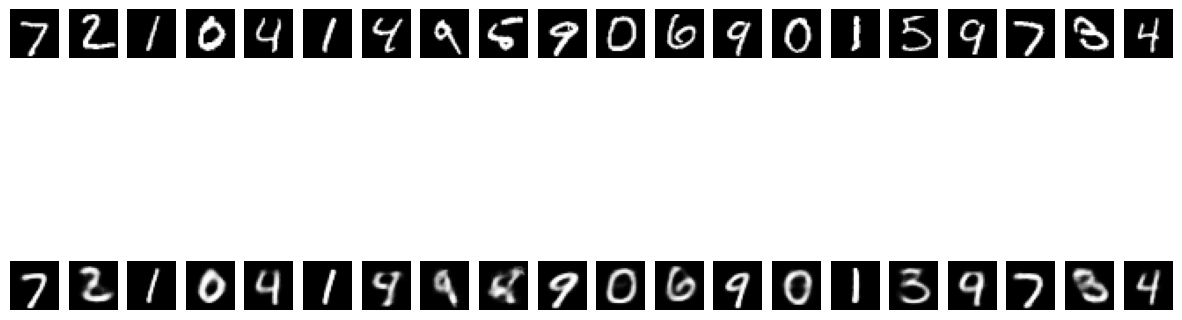

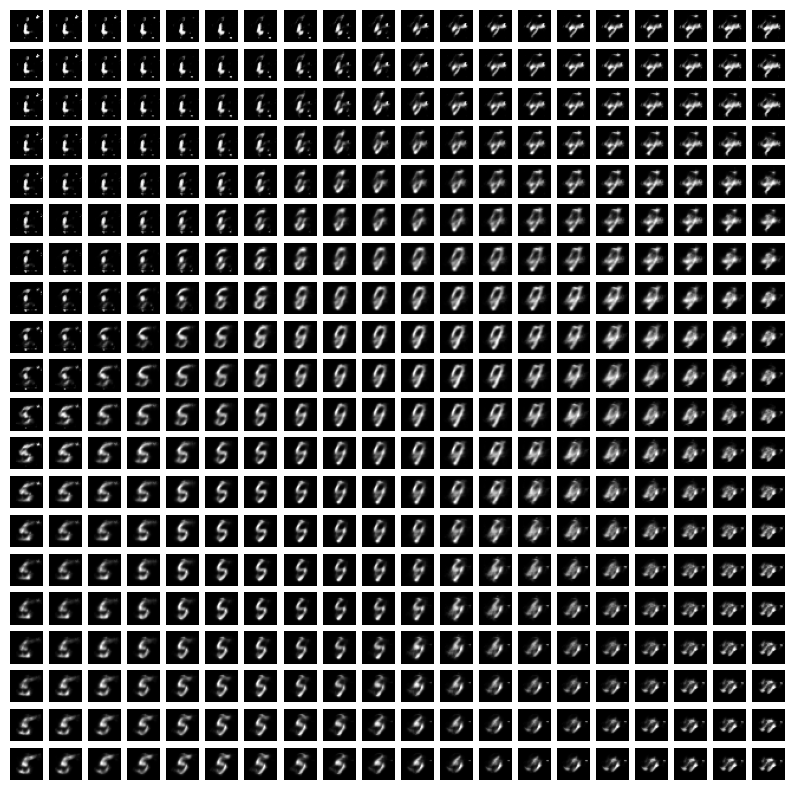

In [ ]:
# Train the model
EPOCH_NUMBER = 20
FEATURE_SIZE = 784 # 28 * 28
HIDDEN_SIZE = 400
LATENT_SIZE = 20
LEARNING_RATE = 1e-2
TRAINING_BATCH_SIZE = 128

model = VAE(HIDDEN_SIZE, LATENT_SIZE, FEATURE_SIZE).to(device)
optimizer = optim.Adam(model.parameters(), LEARNING_RATE)
training_loader = DataLoader(training_set, TRAINING_BATCH_SIZE, True)

for epoch in range(1, EPOCH_NUMBER + 1):
    train(model, optimizer, training_loader, device)
    print(f"Epoch: {epoch:02d} / {EPOCH_NUMBER + 1:02d}")

# Reconstruct and visualise the input images to evaluate the latent space.
TEST_BATCH_SIZE = 20

test_loader = DataLoader(test_set, TEST_BATCH_SIZE, False)
x = next(iter(test_loader))[0]

print(x.shape)
reconstruct(model, x, device)

# Generate and visualise images to traverse the latent space.
RESOLUTION = 20

generate(model, RESOLUTION, device)

You should now experiment with different architectures and hyperparameters until you are satisfied with your model and briefly document your experiments as well as briefly explaining the visualisations below.



As can be seen above, our model can recover input images with near-perfect accuracy. Curves seem marginally harder to accurately recover, as can be seen in the 12th and 19th trial image where the recovered image shows subtle deviations from the input. Interestingly, increasing the learning rate from `1e-3` to `1e-2` leads to fuzzier images in the input recovery task, but the latent space traversal generates more images that actually resemble digits when compared to the latant space generated with a smaller learning rate.